# Experiment 1

- Few Parameters (2x2) => 4 model runs
- existing market pressure as the initial prices are not proportional to trade sizes
- 5 LPs providing entirety of respective tokens (1-5) each
- one trader executing random actions with probabilities:
    - 'sell_r2_for_r1': 0.5,
    - 'sell_r1_for_r2': 0,
    - 'sell_r4_for_r3': 0.25,
    - 'sell_r3_for_r4': 0.25
- asset 5 is not affected by trader's actions

## Setup for initialization

- Asset balances in the Omnipool:
    - Asset 1: 7,000
    - Asset 2: 90,000
    - Asset 3: 13,000,000
    - Asset 4: 8,300,000
- LERNA balances in the Omnipool:
    - Against Asset 1: 117,000,000
    - Against Asset 2: 109,000,000
    - Against Asset 3: 80,000,000
    - Against Asset 4: 15,500,000

In [1]:
import numpy as np

In [2]:
asset1 = 7000
asset2 = 90000
asset3 = 13000000
asset4 = 8300000
asset5 = 100000

# reassign to 0-4

In [3]:
initial_assets_in_pool = np.array([asset1, asset2, asset3, asset4, asset5])
initial_assets_in_pool

array([    7000,    90000, 13000000,  8300000,   100000])

In [4]:
lerna1 = 117000000
lerna2 = 109000000
lerna3 = 80000000
lerna4 = 15500000
lerna5 = 100000


In [5]:
initial_lerna_in_pool = np.array([lerna1, lerna2, lerna3, lerna4, lerna5])
initial_lerna_in_pool

array([117000000, 109000000,  80000000,  15500000,    100000])

In [6]:
initial_prices_in_pool = initial_lerna_in_pool / initial_assets_in_pool 
#initial_prices_in_pool = initial_assets_in_pool / initial_lerna_in_pool ## this is the WRONG one
initial_prices_in_pool

array([1.67142857e+04, 1.21111111e+03, 6.15384615e+00, 1.86746988e+00,
       1.00000000e+00])

In [7]:
#data_f['int'] = data_f['test'].astype('int64')

### calculate prices (denominated in LERNA)

In [8]:
p1 = lerna1 / asset1 
p2 = lerna2 / asset2  
p3 = lerna3 / asset3 
p4 = lerna4 / asset4  
p5 = lerna5 / asset5 
prices = [p1, p2, p3, p4, p5]
prices = initial_prices_in_pool
prices

array([1.67142857e+04, 1.21111111e+03, 6.15384615e+00, 1.86746988e+00,
       1.00000000e+00])

In [9]:
#from model.model_initialization import * 
#initialize_model([1000000, 1500000, 2000000, 2500000, 3000000], 100, 0.01, 0.00)

In [10]:
#########################################################
#           import of packages & dependencies
#########################################################
import pandas as pd

from IPython.core.debugger import Pdb
ipdb = Pdb()

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *
from model.model_initialization import * 

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#########################################################
#     setting of experiment variables & parameters
#########################################################

# fee_levels_total = 0.005, 0.050
# fee_level_assets = fee_levels_total / 2
# fee_level_hdx = fee_levels_total / 2

fee_level_assets = (0.0000, 0.0001, 0.0002, 0.0003, 0.0004) #10-50bps
fee_level_assets = (0.0000, 0.0001)
fee_level_hdx = 0.00
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
#trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
#liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)
trade_volume = [100, 110, 120]
trade_volume = [1, 2] ##scale for reasonable size required
#liquidity_providers = [1000000, 1500000, 2000000, 2500000, 3000000]
liquidity_providers = initial_lerna_in_pool

sim_nr = 0

#########################################################
#     specification of agent (for non-hard-coded calculations)
#########################################################

performance_of_agent = 'LP3'


if performance_of_agent == 'LP1':
    asset_of_agent = 'omniR1'
elif performance_of_agent == 'LP2':
    asset_of_agent = 'omniR2'
elif performance_of_agent == 'LP3':
    asset_of_agent = 'omniR3'

#########################################################
#     preparation of empty result matrix
#########################################################

m=len(trade_volume)
n=len(fee_level_assets)
matrix = np.ndarray(shape = (m,n), dtype = int)
matrix1 = np.ndarray(shape = (m,n), dtype = int).astype('int64')
matrix2 = np.ndarray(shape = (m,n), dtype = int).astype('int64')
matrix3 = np.ndarray(shape = (m,n), dtype = int).astype('int64')
matrix4 = np.ndarray(shape = (m,n), dtype = int).astype('int64')
matrix5 = np.ndarray(shape = (m,n), dtype = int).astype('int64')
matrix_ror = np.ndarray(shape = (m,n), dtype = int)
matrix_ror1 = np.ndarray(shape = (m,n), dtype = float)
matrix_ror2 = np.ndarray(shape = (m,n), dtype = float)
matrix_ror3 = np.ndarray(shape = (m,n), dtype = float)
matrix_ror4 = np.ndarray(shape = (m,n), dtype = float)
matrix_ror5 = np.ndarray(shape = (m,n), dtype = float)


#########################################################
#     repeated simulation runs with above parameters
#########################################################


for i in range(len(fee_level_assets)):
    for j in range(len(trade_volume)):
        #########################################################
        # initialize model with starting conditions for each run
        #########################################################
        
        config_params = initialize_model(initial_lerna_in_pool, trade_volume[j], fee_level_assets[i], fee_level_hdx, initial_prices_in_pool, initial_assets_in_pool)
        
        #########################################################
        # run model with above initialization
        #########################################################
        
        config_dict, state = init_utils.get_configuration(config_params)

        pd.options.mode.chained_assignment = None  # default='warn'
        pd.options.display.float_format = '{:.2f}'.format
        
        run.config(config_dict, state)
        events = run.run()
        
        rdf, agent_df = processing.postprocessing(events)

        #########################################################
        # calculate profitability metrics; change in pool values
        #########################################################
        
         
        print(sim_nr)
        total_timesteps = config_params.get('action_ls')[0][1] #grabbing the same total timestep as through initialize_model
        #total_timesteps = 1000
        first_timestep = 1
        print(total_timesteps)
        
        ## merge agent and pool dataframes
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        
        ## assign additional columns
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        initial_values = config_params['initial_values']
        agent_d = config_params['agent_d']
        withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
        print(withdraw_agent_d)
        profit_results['val_hold'] = profit_results.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
        #profit_results['IL'] = profit_results.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
        profit_results['pool_val'] = profit_results.apply(lambda x: processing.pool_val(x), axis=1)
        
        ## calculate profits from 'val_pool' for initialized agent     
        profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
        profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
        profit_results3 = profit_results1[profit_results1['timestep'] == first_timestep]
        profit_results4 = profit_results2[profit_results2['agent_label'] == performance_of_agent] #define selection for final timestep for desired agent (LP1 / LP2 / ??)
        profit_results5 = profit_results3[profit_results3['agent_label'] == performance_of_agent] #define selection for first timestep for desired agent (LP1 / LP2 / ??)
 
        ## calculate profits from 'val_pool' for hardcored agents (workaround)
        profit_results41 = profit_results2[profit_results2['agent_label'] == 'LP1']
        profit_results51 = profit_results3[profit_results3['agent_label'] == 'LP1']
        profit_results42 = profit_results2[profit_results2['agent_label'] == 'LP2']
        profit_results52 = profit_results3[profit_results3['agent_label'] == 'LP2']
        profit_results43 = profit_results2[profit_results2['agent_label'] == 'LP3']
        profit_results53 = profit_results3[profit_results3['agent_label'] == 'LP3']
        profit_results44 = profit_results2[profit_results2['agent_label'] == 'LP4']
        profit_results54 = profit_results3[profit_results3['agent_label'] == 'LP4']
        profit_results45 = profit_results2[profit_results2['agent_label'] == 'LP5']
        profit_results55 = profit_results3[profit_results3['agent_label'] == 'LP5']
        
        profit_sim0 = profit_results4['val_pool'].iloc[0] - profit_results5['val_pool'].iloc[0] # 
        profit_sim1 = profit_results41['val_pool'].iloc[0] - profit_results51['val_pool'].iloc[0] # profit for LP1
        profit_sim2 = profit_results42['val_pool'].iloc[0] - profit_results52['val_pool'].iloc[0] # profit for LP2
        profit_sim3 = profit_results43['val_pool'].iloc[0] - profit_results53['val_pool'].iloc[0] # profit for LP3
        profit_sim4 = profit_results44['val_pool'].iloc[0] - profit_results54['val_pool'].iloc[0] # profit for LP2
        profit_sim5 = profit_results45['val_pool'].iloc[0] - profit_results55['val_pool'].iloc[0] # profit for LP3
        
        ## calculate 'rate of return' in basispoints
        ror0 = (profit_sim0 / agent_d[performance_of_agent][asset_of_agent]) * 100
        ror1 = (profit_sim1 / agent_d['LP1']['omniR1']) * 100 # RoR for LP1 in %
        ror2 = (profit_sim2 / agent_d['LP2']['omniR2']) * 100 # RoR for LP2 in %
        ror3 = (profit_sim3 / agent_d['LP3']['omniR3']) * 100 # RoR for LP3 in %
        ror4 = (profit_sim4 / agent_d['LP4']['omniR4']) * 100 # RoR for LP4 in %
        ror5 = (profit_sim5 / agent_d['LP5']['omniR5']) * 100 # RoR for LP5 in %
                    
        #########################################################
        # assign metrics (profit, ror) to empty matrix
        #########################################################
        
        #matrix[j][i] = np.random.randint(1, 100 + 1)
        #matrix[j][i] = trade_volume[i]*liquidity[j]
        matrix[j][i] = profit_sim0
        matrix1[j][i] = profit_sim1
        matrix2[j][i] = profit_sim2
        matrix3[j][i] = profit_sim3
        matrix4[j][i] = profit_sim4
        matrix5[j][i] = profit_sim5
        #matrix1[j][i] = profit_sim1
        matrix_ror[j][i] = ror0
        matrix_ror1[j][i] = ror1
        matrix_ror2[j][i] = ror2
        matrix_ror3[j][i] = ror3
        matrix_ror4[j][i] = ror4
        matrix_ror5[j][i] = ror5
        #matrix_ror1[j][i] = ror1
        
        #########################################################
        ## increase simulation count
        #########################################################
        
        sim_nr += 1




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (120, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.20s
0
120
{'Trader': {'q': 1000000, 's': [0, 0, 0, 0, 0], 'r': [1000000, 1000000, 1000000, 1000000, 1000000], 'p': [0, 0, 0, 0, 0]}, 'LP1': {'q': 1955454428571.4285, 's': [0, 0, 0, 0, 0], 'r': [7000, 0, 0, 0, 0], 'p': [16714.285714285714, 0, 0, 0, 0]}, 'LP2': {'q': 131902111111.11111, 's': [0, 0, 0, 0, 0], 'r': [0, 90000, 0, 0, 0], 'p': [0, 1211.111111111111, 0, 0, 0]}, 'LP3': {'q': 412307692.30769235, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 13000000, 0, 0], 'p': [0, 0, 6.153846153846154, 0, 0]}, 'LP4': {'q': 1

## Results

### Absolute Returns for LPs

In [11]:
x_axis_labels = fee_level_assets
y_axis_labels = trade_volume

### Selected Agent

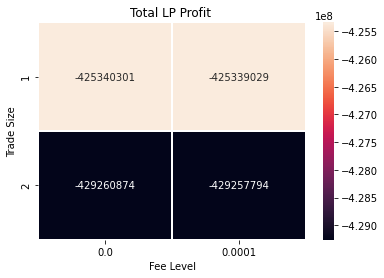

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 1

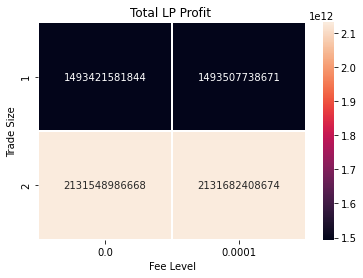

In [13]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 2

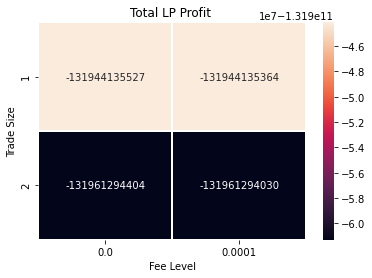

In [14]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 3

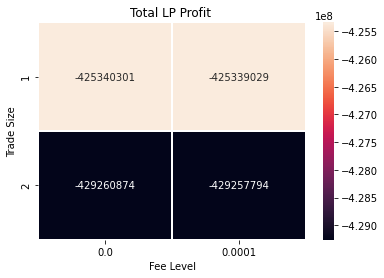

In [15]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix3, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 4

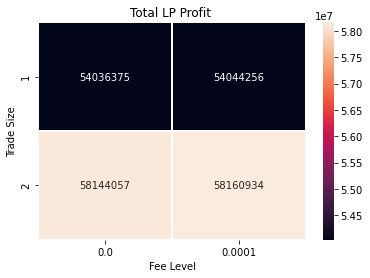

In [16]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix4, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 5

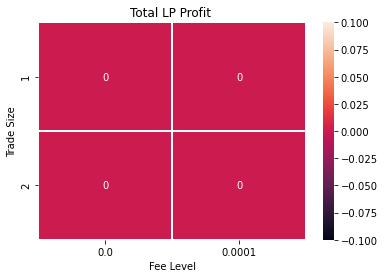

In [17]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".0f")
ax.set_title("Total LP Profit ")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

## Relative Returns for LPs

In [18]:
matrix_ror

array([[-531, -531],
       [-536, -536]])

In [19]:
x_axis_labels

(0.0, 0.0001)

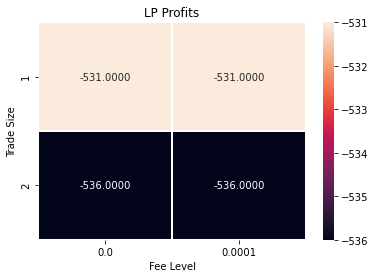

In [20]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 1

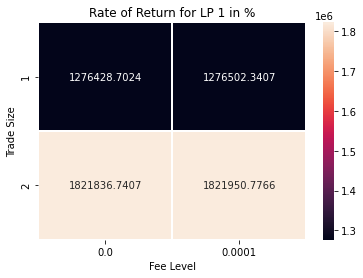

In [21]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("Rate of Return for LP 1 in %")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()


### LP 2

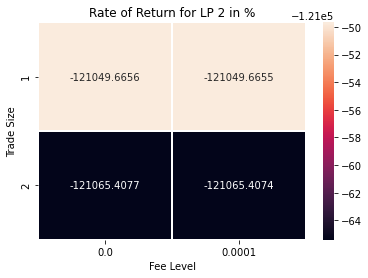

In [22]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("Rate of Return for LP 2 in %")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 3

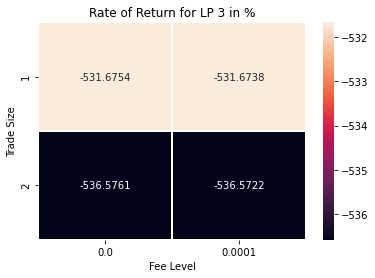

In [23]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror3, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("Rate of Return for LP 3 in %")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 4

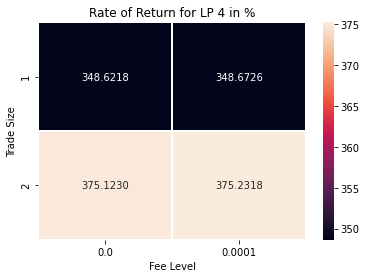

In [24]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror4, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("Rate of Return for LP 4 in %")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 5

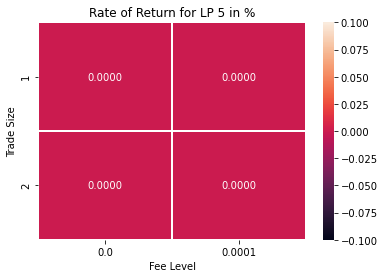

In [25]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5, annot=True, fmt=".4f")
ax.set_title("Rate of Return for LP 5 in %")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

[0]


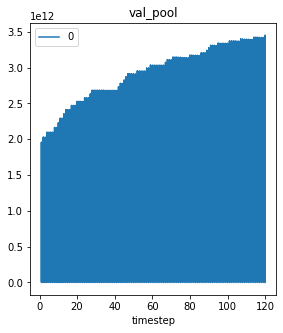

In [26]:
from model import plot_utils as pu
varlist = ['val_pool']
dataframe = profit_results[profit_results['simulation'] == 0]
dataframe = dataframe[dataframe['substep'] == 3]
dataframe = dataframe[dataframe['run'] == 1]
#dataframe = dataframe[dataframe['agent_label'] == 'LP4']
pu.plot_vars(dataframe, varlist)

In [27]:
profit_results['Q-0']

0      117000000.00
1      117000000.00
2      117000000.00
3      117000000.00
4      117000000.00
           ...     
2875   176189800.86
2876   176189800.86
2877   176189800.86
2878   176189800.86
2879   176189800.86
Name: Q-0, Length: 2880, dtype: float64

In [28]:
profit_results['R-0']

0      7000.00
1      7000.00
2      7000.00
3      7000.00
4      7000.00
         ...  
2875   4648.80
2876   4648.80
2877   4648.80
2878   4648.80
2879   4648.80
Name: R-0, Length: 2880, dtype: float64

In [29]:
profit_results.columns.unique

<bound method Index.unique of Index(['simulation', 'subset', 'run', 'substep', 'timestep', 'agent_label',
       'q', 's-0', 's-1', 's-2', 's-3', 's-4', 'r-0', 'r-1', 'r-2', 'r-3',
       'r-4', 'p-0', 'p-1', 'p-2', 'p-3', 'p-4', 'R-0', 'R-1', 'R-2', 'R-3',
       'R-4', 'Q-0', 'Q-1', 'Q-2', 'Q-3', 'Q-4', 'S-0', 'S-1', 'S-2', 'S-3',
       'S-4', 'A-0', 'A-1', 'A-2', 'A-3', 'A-4', 'B-0', 'B-1', 'B-2', 'B-3',
       'B-4', 'D', 'T', 'H', 'token_list-0', 'token_list-1', 'token_list-2',
       'token_list-3', 'token_list-4', 'fee_assets', 'fee_HDX', 'n',
       'val_pool', 'val_hold', 'pool_val'],
      dtype='object')>